# Volumetry Analysis
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32), will expand to PPMI and ADNI NC after QCed.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [1]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file  = data_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
data_df=data_df.drop(columns=drop_col_list);

210910-16:51:04,668 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0


In [2]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
analysis_list = ['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels
curr_df = data_df[analysis_list]
curr_df['Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df['Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
#print(list(data_df.columns))

/tmp/ipykernel_163/3952807033.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
/tmp/ipykernel_163/3952807033.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];


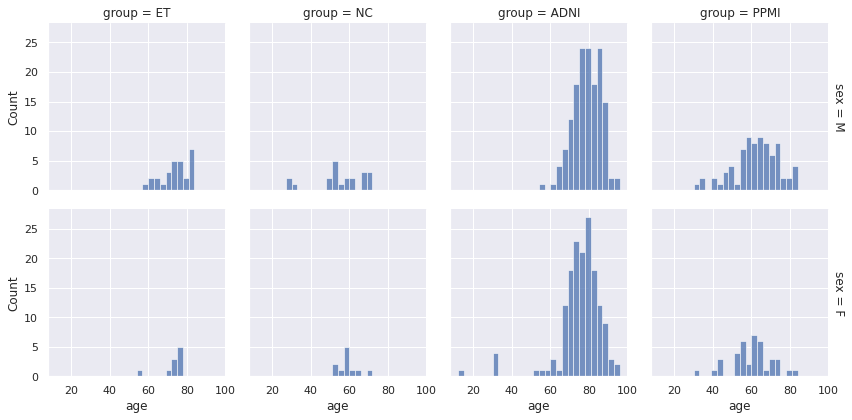

In [3]:
# plot demographic age/sex/group distributions 2*3
sns.set_theme(style="darkgrid")
sns.displot(
    curr_df, x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

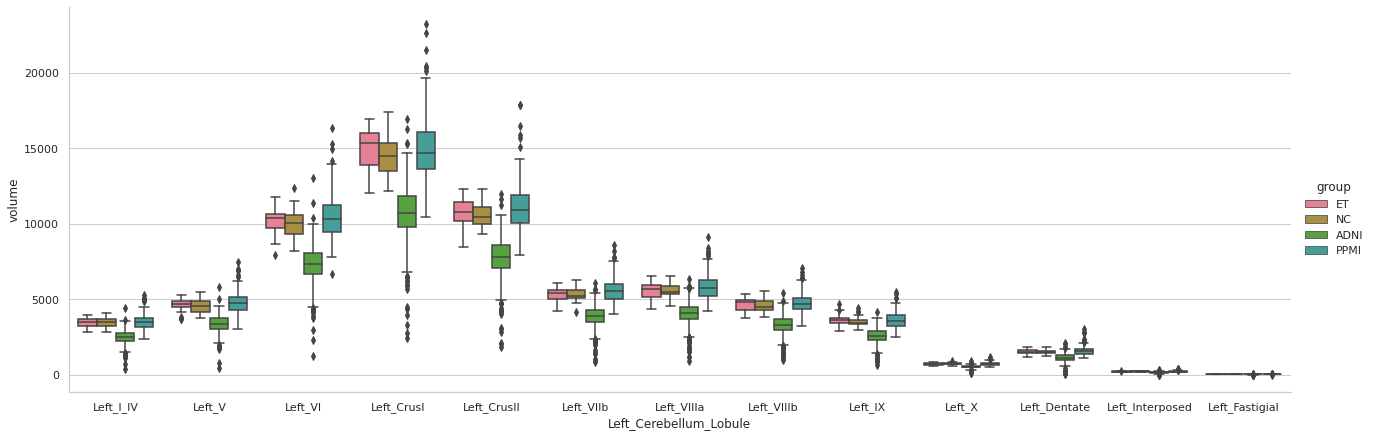

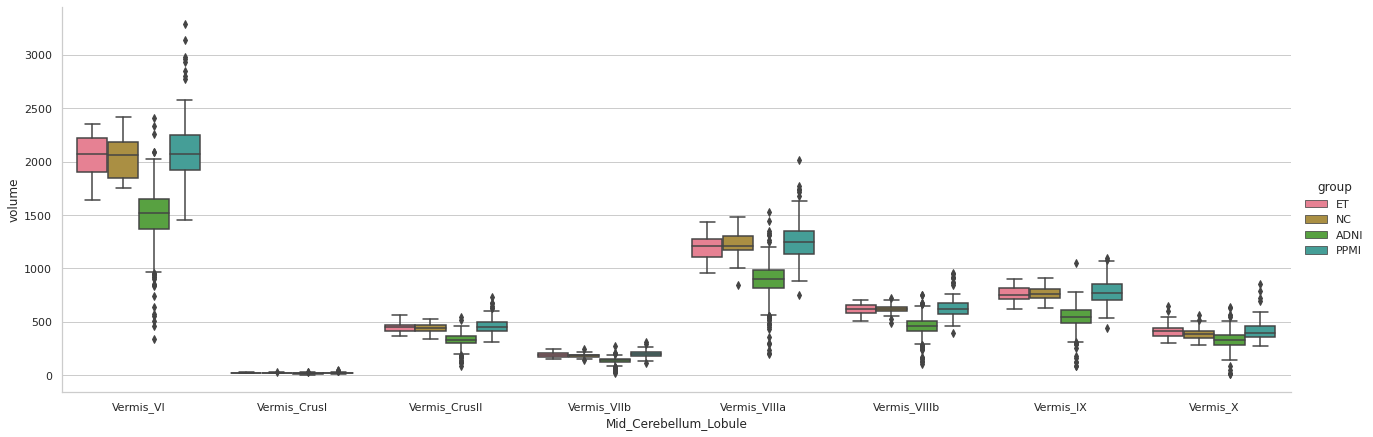

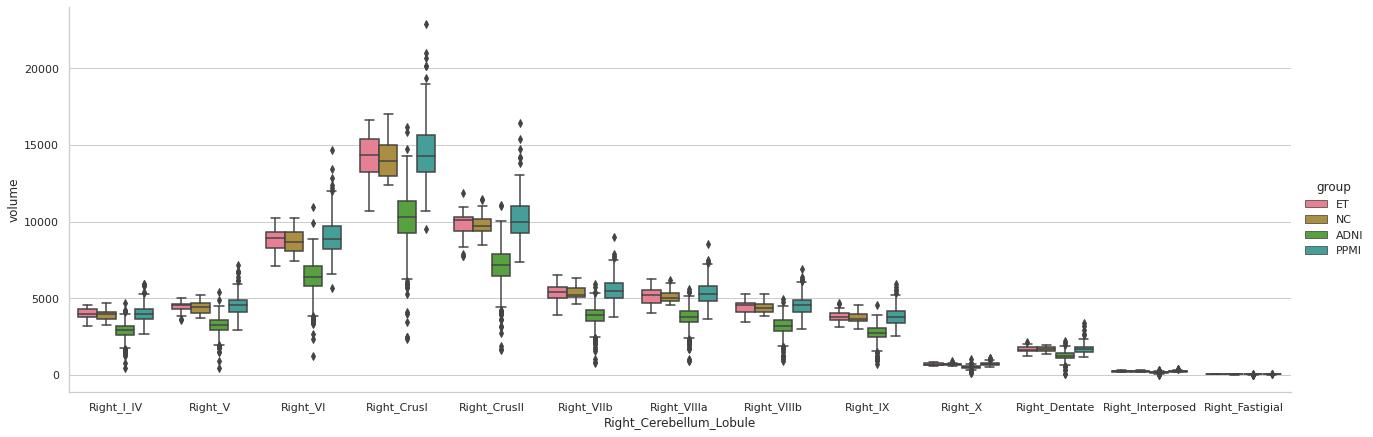

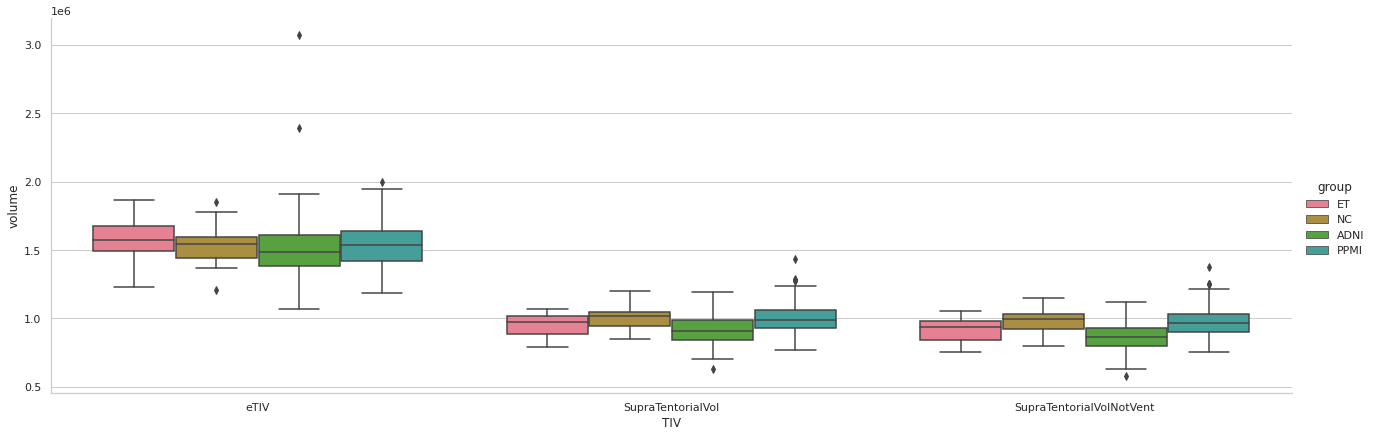

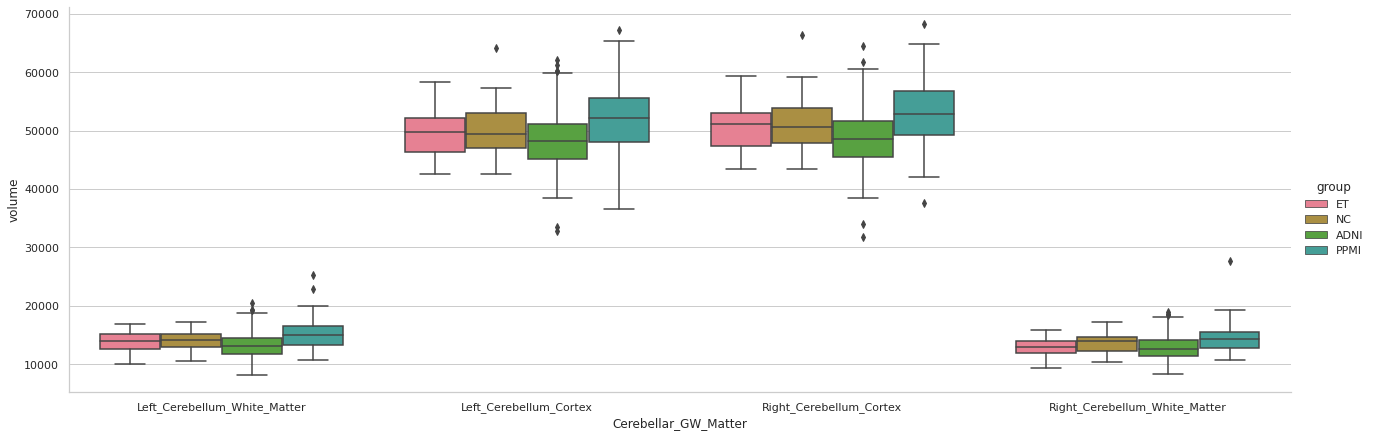

In [4]:
# SUIT lobule results vis
sns.set(font_scale=1)
vis_suit_df=curr_df.copy()
vis_suit_df['participant_id']=vis_suit_df.index
vis_label_cerebellar=['Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
vis_label_tiv = ['eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent']

palette = sns.color_palette('husl', 6)
with sns.axes_style("whitegrid"):
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_l_labels, 
                      var_name ='Left_Cerebellum_Lobule', value_name ='volume')
    g = sns.catplot(y='volume', x='Left_Cerebellum_Lobule', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df)
    plot_v_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_v_labels, 
                      var_name ='Mid_Cerebellum_Lobule', value_name ='volume')
    g1 = sns.catplot(y='volume', x='Mid_Cerebellum_Lobule', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_v_df)
    plot_r_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_r_labels, 
                      var_name ='Right_Cerebellum_Lobule', value_name ='volume')
    g2 = sns.catplot(y='volume', x='Right_Cerebellum_Lobule', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_r_df)
    plot_tiv_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = vis_label_tiv,
                           var_name ='TIV', value_name ='volume')
    g3 = sns.catplot(y='volume', x='TIV', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_tiv_df)
    plot_cere_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = vis_label_cerebellar,
                           var_name ='Cerebellar_GW_Matter', value_name ='volume')
    g4 = sns.catplot(y='volume', x='Cerebellar_GW_Matter', hue='group', kind='box',aspect=3, height=6, palette=palette,
                     data=plot_cere_df)

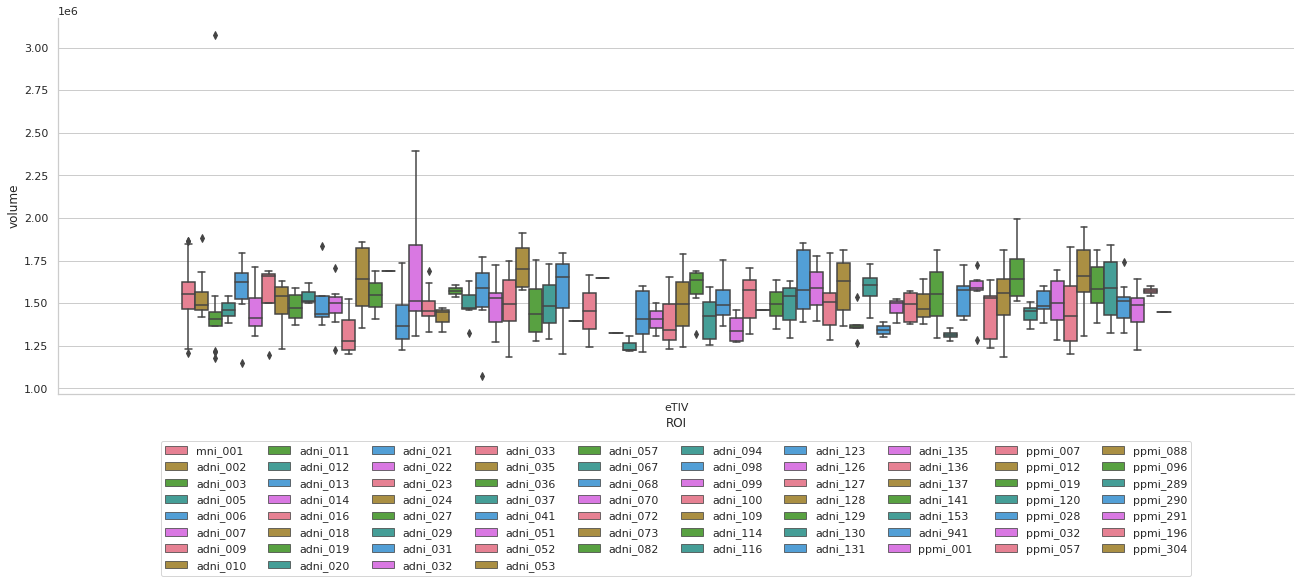

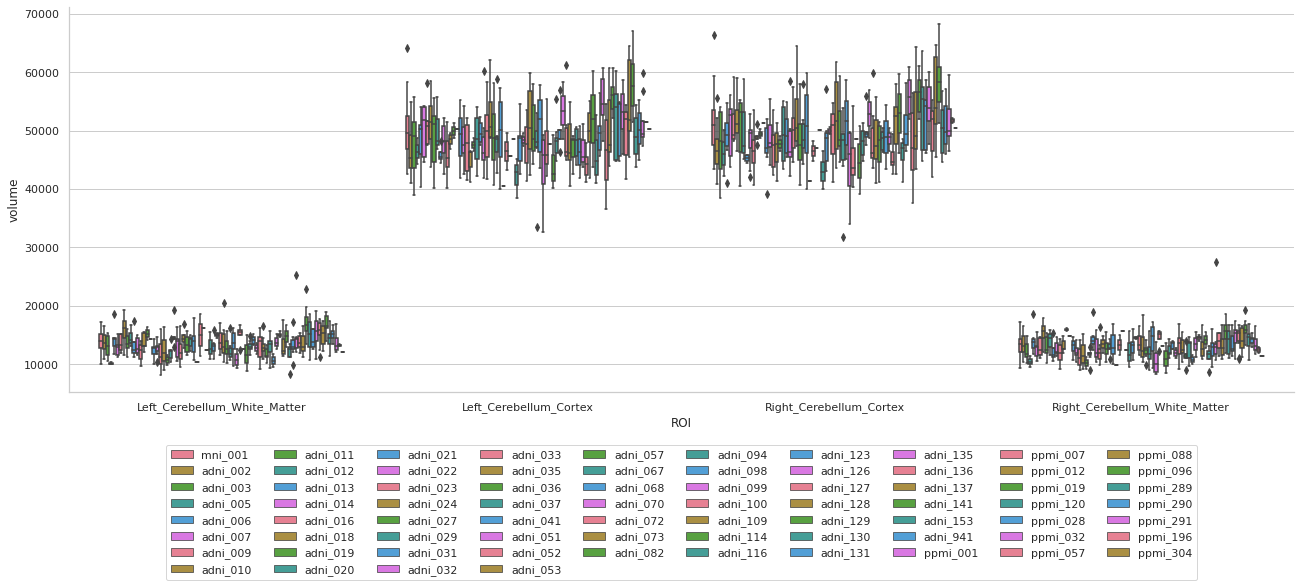

In [5]:
# site effect
# SUIT lobule results vis
sns.set(font_scale=1)
vis_suit_df=curr_df.copy()
vis_suit_df['participant_id']=vis_suit_df.index
# ,'SupraTentorialVol', 'SupraTentorialVolNotVent'
vis_label1 = ['eTIV'];
vis_label2=['Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter']
palette = sns.color_palette('husl', 6)
with sns.axes_style("whitegrid"):
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','site'], value_vars = vis_label1, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='site', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df, legend=0 )
    l1 = plt.legend(bbox_to_anchor=(0.5,-0.5), loc="lower center", ncol=10)
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','site'], value_vars = vis_label2, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='site', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df, legend=0)
    l2 = plt.legend(bbox_to_anchor=(0.5,-0.5), loc="lower center", ncol=10)
    

In [6]:
### statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import glm
import statsmodels.stats as sts
from scipy.stats import ranksums
import pandas as pd
import numpy as np

curr_df['InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol'];
df = curr_df[(curr_df['group']=='ET')|(curr_df['group']=='NC')]
n_permu=10000; alpha=5;
stats_cols = ['voi','group','cohen_d','cohen_p','Wilcoxon','Wilcoxon_p','method'];
#[x for x in curr_data.columns if 'tent' in x.lower()]

/tmp/ipykernel_163/2343466012.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df['InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol'];


In [7]:
## covariate
from utils_et_biomarker.utils import ctr_conf, glm_test, sts_test, rep_model
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];
sts_df = df[info_list+cerebellum_list+lobular_list];

tar_list = cerebellum_list;

# basic GLM
covariate_model_str = '~age+sex+InfraTentorialVol+C(group, Treatment(reference="NC"))';
covariate_dict = glm_test(sts_df, tar_list, covariate_model_str);
covariate_df   = sts_test(tar_list, sts_df, stats_cols, alpha, n_permu, 'covariate')

/usr/local/miniconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/miniconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/miniconda/lib/python3.8/site-packages/scipy/stats/stats.py:7246: 

In [16]:
covariate_dict['Cerebellum_Cortex']['res'].summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                 Results: Generalized linear model
====================================================================================================
Model:                         GLM                         AIC:                      1440.1751      
Link Function:                 identity                    BIC:                      3060032901.8204
Dependent Variable:            Cerebellum_Cortex           Log-Likelihood:           -715.09        
Date:                          2021-09-10 16:55            LL-Null:                  -737.56        
No. Observations:              70                          Deviance:                 3.0600e+09     
Df Model:                      4                           Pearson chi2:             3.06e+09       
Df Residuals:                  65                          Scale:                    4.7077e+07     
Method:                        IRLS                                                                 
----------------------------------------------------------------------------------------------------
                                            Coef.     Std.Err.    z    P>|z|    [0.025      0.975]  
----------------------------------------------------------------------------------------------------
Intercept                                 93723.7469 6619.7137 14.1583 0.0000 80749.3464 106698.1473
sex[T.M]                                   4723.0511 2033.1927  2.3230 0.0202   738.0667   8708.0356
C(group, Treatment(reference="NC"))[T.ET]   -93.0395 2331.6724 -0.0399 0.9682 -4663.0334   4476.9544
age                                        -338.6845   96.8636 -3.4965 0.0005  -528.5337   -148.8353
InfraTentorialVol                             0.0448    0.0115  3.8966 0.0001     0.0222      0.0673
====================================================================================================

"""

In [ ]:
# 'Cerebellum_Cortex','Cerebellum_White_Matter',

# confounding
tab_data, rm_norm_list, rm_norm_reg = ctr_conf(
    sts_df, ['age', 'sex', 'eTIV'], tar_list, 'rm_norm');
tab_data, pcp_list, pcp_reg = ctr_conf(sts_df, 'InfraTentorialVol', tar_list, 'ppa');
tab_data, dpa_list = ctr_conf(sts_df, 'InfraTentorialVol', tar_list, 'dpa');
tab_data, asm_list, asm_reg = ctr_conf(sts_df, 'InfraTentorialVol', tar_list, 'asm');
tab_data, rm_list, rm_reg = ctr_conf(sts_df, 'InfraTentorialVol', tar_list, 'rm_mean');

## dpa
dpa_list = [x+"_dpa" for x in tar_list ];
dpa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
dpa_dict = glm_test(tab_data, dpa_list, dpa_model_str);
dpa_df=sts_test(dpa_list, tab_data, stats_cols, alpha, n_permu, 'dpa');
## ppa
ppa_list = [x+"_ppa" for x in tar_list ];
ppa_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
ppa_dict = glm_test(tab_data, ppa_list, ppa_model_str);
ppa_df=sts_test(ppa_list, tab_data, stats_cols, alpha, n_permu, 'ppa');
## rm_norm
rm_norm_list = [x+"_rm_norm" for x in tar_list ];
rm_norm_model_str = '~C(diagnosis, Treatment(reference="NC"))';
rm_norm_dict = glm_test(tab_data, rm_norm_list, rm_norm_model_str);
rm_norm_df=sts_test(rm_norm_list, tab_data, stats_cols, alpha, n_permu, 'rm_norm');
## rm_mean
rm_mean_list = [x+"_rm_mean" for x in tar_list];
rm_mean_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
rm_mean_dict = glm_test(tab_data, rm_mean_list, rm_mean_model_str);
rm_mean_df=sts_test(rm_mean_list, tab_data, stats_cols, alpha, n_permu, 'rm_mean');
## asm
asm_list = [x+"_asm" for x in tar_list];
asm_model_str = '~age+sex+C(diagnosis, Treatment(reference="NC"))';
asm_dict = glm_test(tab_data, asm_list, asm_model_str);
asm_df   = sts_test(asm_list, tab_data, stats_cols, alpha, n_permu, 'asm');

In [14]:
from matching.utils import reformat_df
from matching.vis import heatmap, annotate_heatmap

sts_df = pd.DataFrame();
sts_df = sts_df.append(covariate_df.append(ppa_df.append(rm_norm_df.append(rm_mean_df.append(asm_df.append(dpa_df, ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True), ignore_index=True)

et_es, et_p, p_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['cohen_d', 'cohen_p']);
pd_es, pd_p, p_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['cohen_d', 'cohen_p']);

et_wil, et_wp, wp_multi_et, voi_name, method_name = reformat_df(sts_df, 'ETNC', ['Wilcoxon', 'Wilcoxon_p']);
pd_wil, pd_wp, wp_multi_pd, voi_name, method_name = reformat_df(sts_df, 'PDNC', ['Wilcoxon', 'Wilcoxon_p']);

#method_name = ['Voi','DPA','PPA','RM-Norm', 'RM-Mean','Allometric Scaling']

import numpy as np
import matplotlib.pyplot as plt
def plot_effectsize(et_es, et_p, p_multi_et, NAME):
    #et_es=et_es[0]; et_p=et_p[0]; p_multi_et=p_multi_et[0];
    import matplotlib.pyplot as plt
    VMIN = 0; VMAX=0.1; C_MAP='coolwarm_r'; es_th = 0.2; f_size=[7,8];
    fig1=plt.figure(figsize=f_size); ax1 = fig1.subplots();
    im1, cbar1 = heatmap(np.array(et_p), method_name, voi_name, ax=ax1, cmap=C_MAP, cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    #texts = annotate_heatmap(im1, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax1.set_title(NAME); fig1.tight_layout(); plt.show()
    fig2=plt.figure(figsize=f_size); ax2 = fig2.subplots();
    im2, cbar2 = heatmap(np.array(p_multi_et), method_name, voi_name, ax=ax2, cmap=C_MAP,cbarlabel="$p$  value", vmin=VMIN, vmax=VMAX)
    #texts = annotate_heatmap(im2, np.array(et_es), valfmt="{x:.4f}", textcolors=["grey", "black"], threshold=es_th)
    ax2.set_title(NAME+' (with BH correction)'); fig2.tight_layout(); plt.show()
    return ax1, ax2

ax1_et_coh, ax2_et_coh = plot_effectsize(et_es, et_p, p_multi_et, 'Cohen $d$ for comparing ET and NC group')
ax1_pd_coh, ax2_pd_coh = plot_effectsize(pd_es, pd_p, p_multi_pd, 'Cohen $d$ for comparing PD and NC group')
ax1_et_wil, ax2_et_wil = plot_effectsize(et_wil, et_wp, wp_multi_et, 'Wilcoxon signed-rank for comparing ET and NC group')
ax1_pd_wil, ax2_pd_wil = plot_effectsize(pd_wil, pd_wp, wp_multi_pd, 'Wilcoxon signed-rank for comparing PD and NC group')


ImportError: cannot import name 'reformat_df' from 'matching.utils' (/codes/matching/utils.py)

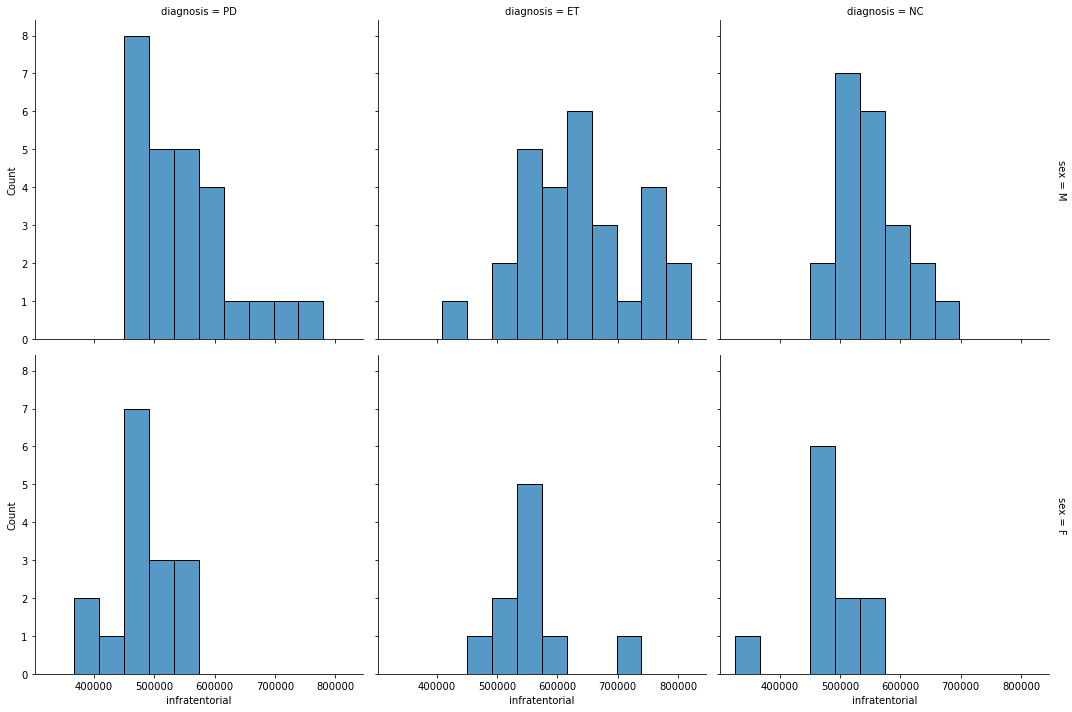

In [11]:
import seaborn as sns
sns.displot(
    curr_data, x="infratentorial", col="diagnosis", row="sex", facet_kws=dict(margin_titles=True))

In [12]:
mdtb_labels = ['MDTB_'+str(x+1) for x in range(10)];
suit_labels = ['Left_I_IV', 'Right_I_IV', 'Left_V', 'Right_V', 'Left_VI', 'Vermis_VI',
               'Right_VI', 'Left_CrusI', 'Vermis_CrusI', 'Right_CrusI', 'Left_CrusII',
               'Vermis_CrusII', 'Right_CrusII', 'Left_VIIb', 'Vermis_VIIb',
               'Right_VIIb', 'Left_VIIIa', 'Vermis_VIIIa', 'Right_VIIIa', 'Left_VIIIb',
               'Vermis_VIIIb', 'Right_VIIIb', 'Left_IX', 'Vermis_IX', 'Right_IX',
               'Left_X', 'Vermis_X', 'Right_X', 'Left_Dentate', 'Right_Dentate',
               'Left_Interposed', 'Right_Interposed', 'Left_Fastigial','Right_Fastigial'];